# Models for House Prices: Advanced Regression Techniques

@roman avj

27 jan 2024

# Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split

import catboost as cb
from sklearn.linear_model import LinearRegression

# create pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
# column transformer
from sklearn.compose import ColumnTransformer
# rmse, mae, mape
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error



# Data

In [2]:
# read data
df_raw = pd.read_csv('../data/train.csv')

# get shapes
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [3]:
# wrangle data
def tidy_df(df):
    # get params
    CURR_YEAR = 2010
    # transform
    df = (
        df
        #### var engineer ####
        .assign(
            CurrentAge=lambda dfx: CURR_YEAR - np.maximum(dfx['YearBuilt'], dfx['YearRemodAdd']),
            PorchArea=lambda dfx: dfx['OpenPorchSF'] + dfx['EnclosedPorch'] +\
                 dfx['3SsnPorch'] + dfx['ScreenPorch'],
            TotalBaths=lambda dfx: dfx['FullBath'] + dfx['HalfBath'],
            Story=lambda dfx: np.select(
                [
                    dfx['HouseStyle'].str.contains('1Story'),
                    dfx['HouseStyle'].str.contains('1.5Fin'),
                    dfx['HouseStyle'].str.contains('1.5Unf'),
                    dfx['HouseStyle'].str.contains('2Story'),
                    dfx['HouseStyle'].str.contains('2.5Fin'),
                    dfx['HouseStyle'].str.contains('2.5Unf'),
                    dfx['HouseStyle'].str.contains('SFoyer'),
                    dfx['HouseStyle'].str.contains('SLvl')
                ],
                [
                    'one',
                    'one_and_half',
                    'one_and_half',
                    'two',
                    'two_and_half',
                    'two_and_half',
                    'split',
                    'split'
                ]
            ),
            StoryFinish=lambda dfx: np.where(
                dfx['HouseStyle'].str.contains('Unf'), 'unfinished', 'finished'
            ),
        )
        #### transform ####
        .assign(
            LogSalePrice=lambda dfx: np.log(dfx['SalePrice'])
        )        
    )

    return df

def subset_df(df, cols):
    df = (
        df
        #### filters ####
        # no properties with 0 bedrooms or 0 bathrooms
        .query('TotRmsAbvGrd > 0 and TotalBaths > 0')
        # no lot area bigger than 200,000 sqft
        .query('LotArea < 200000')
        # no porch area bigger than 1,000 sqft
        .query('PorchArea < 1000')
        # subset by sale type
        .query('SaleType in ["WD", "New"]')
        # subset by sale condition
        .query('SaleCondition in ["Normal", "Partial"]')
        # subset by mszoning
        .query('MSZoning in ["RL", "RM", "RP", "RH"]')
    )
    # subset
    df = df[cols].reset_index(drop=True)
    return df

# tidy data #
# cols
colsnumeric = [
    'CurrentAge',
    'LotArea', 'PorchArea',
    'TotRmsAbvGrd', 'TotalBaths',
    'OverallQual', 'OverallCond', 'GrLivArea'
]
cat_cols = [
    'SaleType', 'SaleCondition', 
    'MSZoning',
    'Story', 'StoryFinish'
]
cols = colsnumeric + cat_cols + ['Id', 'LogSalePrice']
# tidy
df = tidy_df(df_raw)
df = subset_df(df, cols)

# get info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CurrentAge     1218 non-null   int64  
 1   LotArea        1218 non-null   int64  
 2   PorchArea      1218 non-null   int64  
 3   TotRmsAbvGrd   1218 non-null   int64  
 4   TotalBaths     1218 non-null   int64  
 5   OverallQual    1218 non-null   int64  
 6   OverallCond    1218 non-null   int64  
 7   GrLivArea      1218 non-null   int64  
 8   SaleType       1218 non-null   object 
 9   SaleCondition  1218 non-null   object 
 10  MSZoning       1218 non-null   object 
 11  Story          1218 non-null   object 
 12  StoryFinish    1218 non-null   object 
 13  Id             1218 non-null   int64  
 14  LogSalePrice   1218 non-null   float64
dtypes: float64(1), int64(9), object(5)
memory usage: 142.9+ KB


In [4]:
# percent of filtered rows
print(f"percent of filtered rows: {round(100*(1 - df.shape[0]/df_raw.shape[0]), 2)}%")

percent of filtered rows: 16.58%


In [5]:
# set index to id
df.set_index('Id', inplace=True)

# split data
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['LogSalePrice'], axis=1), df['LogSalePrice'], test_size=0.1, random_state=42, stratify=df['SaleType']
)

# Models

## All vars

### Baseline Model

In [6]:
# pipeline for categorical and numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, colsnumeric),
        ('cat', categorical_transformer, cat_cols)
    ]
)

# linear regression
lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
# fit
lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['CurrentAge', 'LotArea',
                                                   'PorchArea', 'TotRmsAbvGrd',
                                                   'TotalBaths', 'OverallQual',
                                                   'OverallCond',
                                                   'GrLivArea']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['SaleType', 'SaleCondition',
                                                   'MSZoning', 'Story',
                                                   'StoryFinish'])])),
                ('regressor', LinearRegression())])

In [7]:
def regression_metrics(y_true, y_pred, exp=False):
    if exp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
    # rmse
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    # mae
    mae = mean_absolute_error(y_true, y_pred)
    # mape
    mape = mean_absolute_percentage_error(y_true, y_pred)

    if exp:
        print("metrics")
    else:
        print("metrics (log)")
    print(f"{'='*50}")
    print(f"rmse: {np.round(rmse, 4)}")
    print(f"mae: {np.round(mae, 4)}")
    print(f"mape: {np.round(mape, 4)}")
    print("\n\n")


# predict
y_pred = lr.predict(X_test)

# get metrics
regression_metrics(y_test, y_pred)
regression_metrics(y_test, y_pred, exp=True)

metrics (log)
rmse: 0.1532
mae: 0.1124
mape: 0.0094



metrics
rmse: 31168.4506
mae: 20971.008
mape: 0.1179





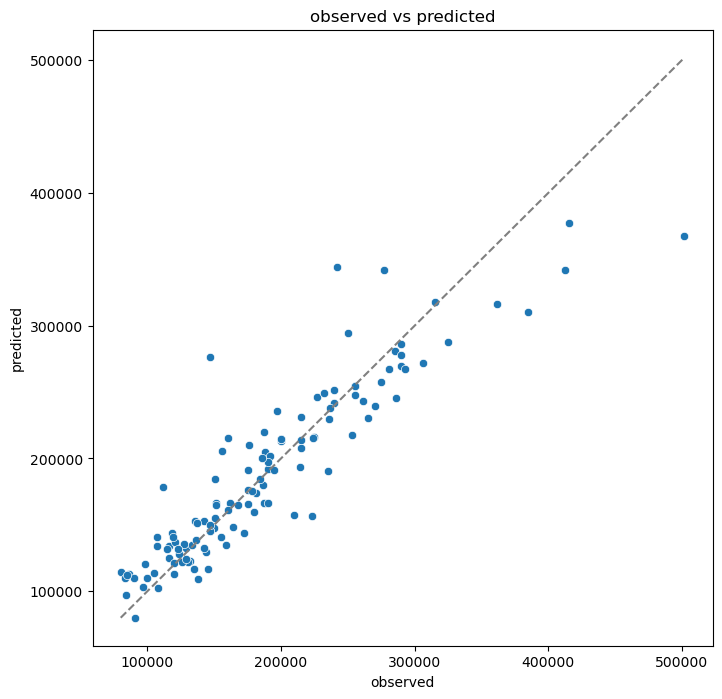

In [8]:
# plot observed vs predicted
plt.figure(figsize=(8, 8))
# add identity line
plt.plot([np.exp(y_test).min(), np.exp(y_test).max()], [np.exp(y_test).min(), np.exp(y_test).max()], c='gray', linestyle='--')
# get residuals
sns.scatterplot(x=np.exp(y_test), y=np.exp(y_pred))
plt.xlabel('observed')
plt.ylabel('predicted')
plt.title('observed vs predicted')
plt.show()

### CatBoost

In [9]:
# fit catboost
cb_model = cb.CatBoostRegressor(
    loss_function='RMSE',
    iterations=1000,
    learning_rate=0.01,
    random_seed=42,
    verbose=True
)
# fit
cb_model.fit(X_train, y_train, cat_features=cat_cols, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3879139	total: 64ms	remaining: 1m 3s
1:	learn: 0.3853510	total: 66.6ms	remaining: 33.3s
2:	learn: 0.3828345	total: 67.8ms	remaining: 22.5s
3:	learn: 0.3803755	total: 69.9ms	remaining: 17.4s
4:	learn: 0.3779199	total: 71.9ms	remaining: 14.3s
5:	learn: 0.3753720	total: 73.1ms	remaining: 12.1s
6:	learn: 0.3731070	total: 74.6ms	remaining: 10.6s
7:	learn: 0.3707253	total: 75.6ms	remaining: 9.38s
8:	learn: 0.3685393	total: 76.5ms	remaining: 8.43s
9:	learn: 0.3663334	total: 78.4ms	remaining: 7.76s
10:	learn: 0.3639153	total: 79.9ms	remaining: 7.18s
11:	learn: 0.3617646	total: 82ms	remaining: 6.75s
12:	learn: 0.3596601	total: 83.7ms	remaining: 6.36s
13:	learn: 0.3574362	total: 85.2ms	remaining: 6s
14:	learn: 0.3552068	total: 86.9ms	remaining: 5.7s
15:	learn: 0.3530926	total: 88.9ms	remaining: 5.47s
16:	learn: 0.3513915	total: 89.6ms	remaining: 5.18s
17:	learn: 0.3491300	total: 91.1ms	remaining: 4.97s
18:	learn: 0.3471443	total: 92.2ms	remaining: 4.76s
19:	learn: 0.3451123	total: 93

In [10]:
# predict
y_pred = cb_model.predict(X_test)

# get metrics
regression_metrics(y_test, y_pred)
regression_metrics(y_test, y_pred, exp=True)


metrics (log)
rmse: 0.13
mae: 0.0898
mape: 0.0075



metrics
rmse: 25310.507
mae: 16417.3892
mape: 0.0942





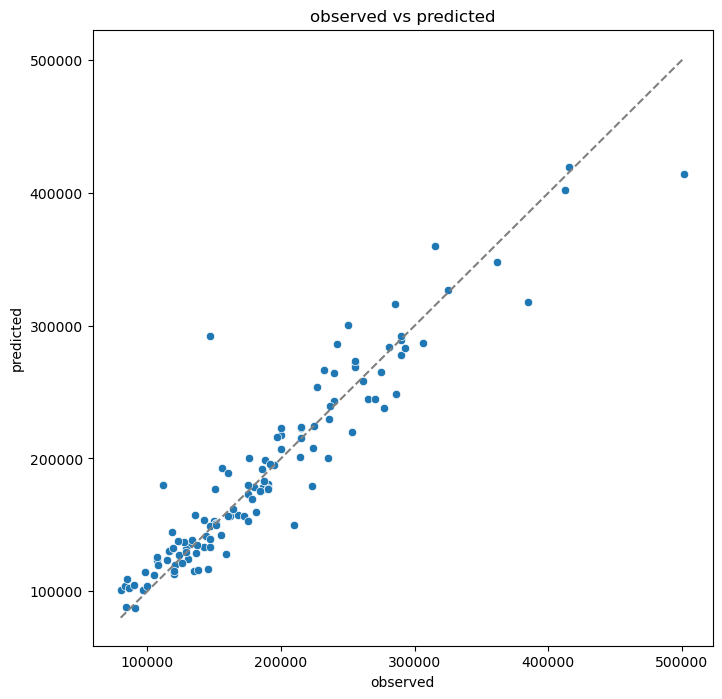

In [11]:
# plot observed vs predicted
plt.figure(figsize=(8, 8))
# add identity line
plt.plot([np.exp(y_test).min(), np.exp(y_test).max()], [np.exp(y_test).min(), np.exp(y_test).max()], c='gray', linestyle='--')
# get residuals
sns.scatterplot(x=np.exp(y_test), y=np.exp(y_pred))
plt.xlabel('observed')  
plt.ylabel('predicted')
plt.title('observed vs predicted')
plt.show()

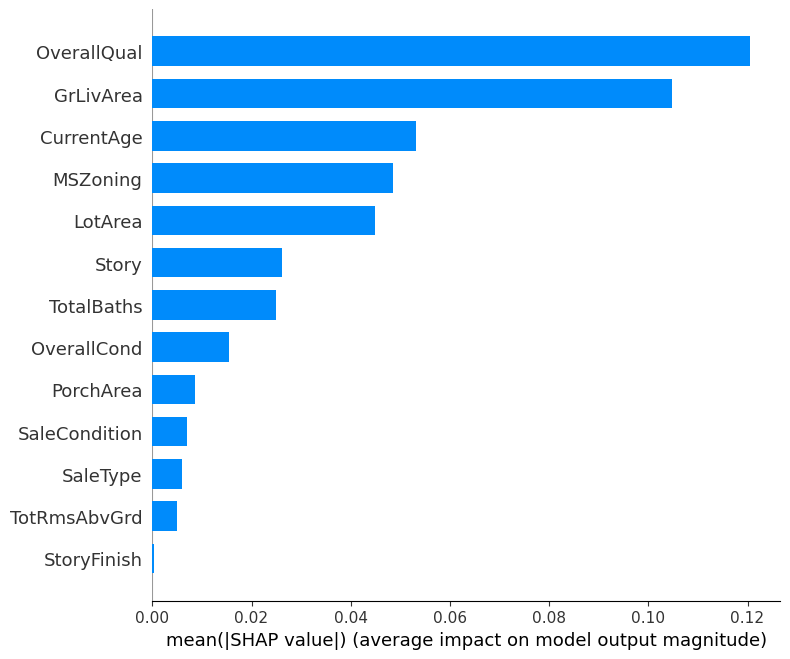

In [12]:
# look shape values
# import Pool
from catboost import Pool
# import shap
import shap
# get shape values
shap_values = cb_model.get_feature_importance(Pool(X_train, label=y_train, cat_features=cat_cols), type='ShapValues')
# plot
plt.figure(figsize=(8, 8))
shap.summary_plot(shap_values[:, :-1], X_train, plot_type='bar')
plt.show()


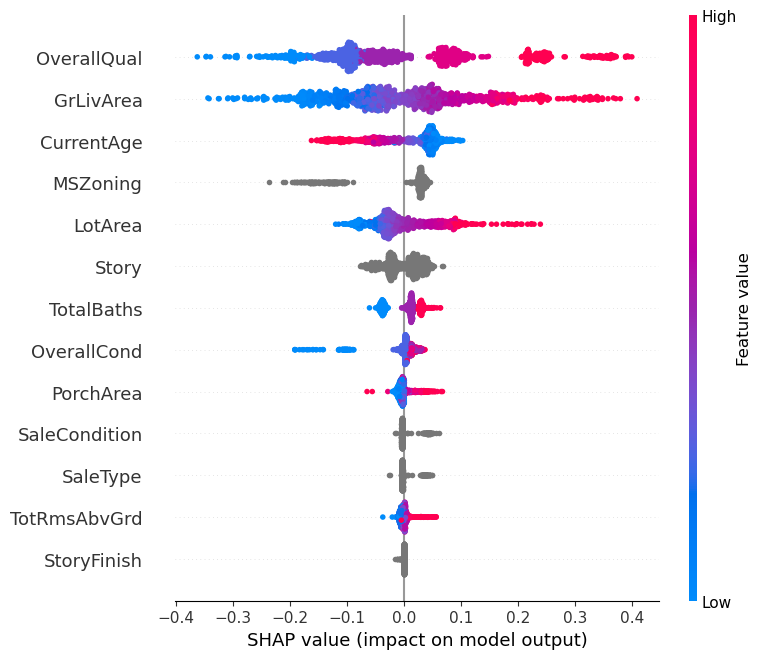

In [13]:
# plot bee swarm
plt.figure(figsize=(8, 8))
shap.summary_plot(shap_values[:, :-1], X_train)
plt.show()

## Subset vars

In [14]:
# cols
colsnumeric = [
    'CurrentAge', 'GrLivArea',
    'LotArea', 'OverallCond',
    'OverallQual'
]
cat_cols = [
    'MSZoning'
]
cols = colsnumeric + cat_cols + ['LogSalePrice']

# df work
df_work = df[cols].copy()


# split data
X_train, X_test, y_train, y_test = train_test_split(
    df_work.drop(['LogSalePrice'], axis=1), df_work['LogSalePrice'], 
    test_size=0.1, random_state=42, stratify=df_work['MSZoning']
)


### Linear regression

In [15]:
# pipeline for categorical and numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, colsnumeric),
        ('cat', categorical_transformer, cat_cols)
    ]
)

# linear regression
lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
# fit
lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['CurrentAge', 'GrLivArea',
                                                   'LotArea', 'OverallCond',
                                                   'OverallQual']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['MSZoning'])])),
                ('regressor', LinearRegression())])

In [16]:
# predict
y_pred = lr.predict(X_test)

# get metrics
regression_metrics(y_test, y_pred)
regression_metrics(y_test, y_pred, exp=True)

metrics (log)
rmse: 0.1392
mae: 0.1105
mape: 0.0092



metrics
rmse: 28353.933
mae: 20888.4746
mape: 0.1123





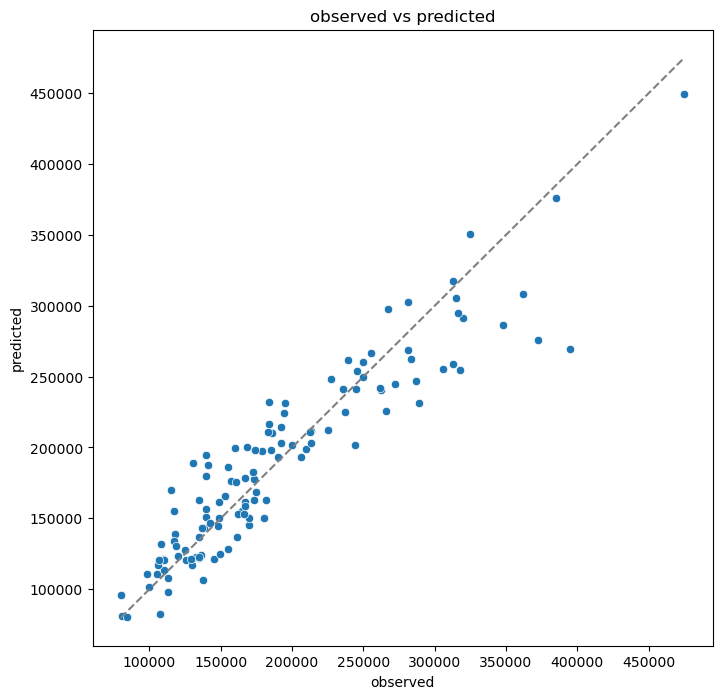

In [17]:
# plot observed vs predicted
plt.figure(figsize=(8, 8))
# add identity line
plt.plot([np.exp(y_test).min(), np.exp(y_test).max()], [np.exp(y_test).min(), np.exp(y_test).max()], c='gray', linestyle='--')
# get residuals
sns.scatterplot(x=np.exp(y_test), y=np.exp(y_pred))
plt.xlabel('observed')
plt.ylabel('predicted')
plt.title('observed vs predicted')
plt.show()

### CatBoost

In [18]:
# fit catboost
cb_model = cb.CatBoostRegressor(
    loss_function='RMSE',
    iterations=1000,
    learning_rate=0.01,
    random_seed=42,
    verbose=True
)
# fit
cb_model.fit(X_train, y_train, cat_features=cat_cols, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3884008	total: 2.37ms	remaining: 2.37s
1:	learn: 0.3858039	total: 3.57ms	remaining: 1.78s
2:	learn: 0.3831228	total: 4.71ms	remaining: 1.56s
3:	learn: 0.3805400	total: 5.92ms	remaining: 1.47s
4:	learn: 0.3780025	total: 7.11ms	remaining: 1.42s
5:	learn: 0.3756163	total: 8.84ms	remaining: 1.46s
6:	learn: 0.3733725	total: 9.89ms	remaining: 1.4s
7:	learn: 0.3711768	total: 10.4ms	remaining: 1.29s
8:	learn: 0.3686828	total: 11.4ms	remaining: 1.25s
9:	learn: 0.3665342	total: 13.7ms	remaining: 1.36s
10:	learn: 0.3642795	total: 17.1ms	remaining: 1.54s
11:	learn: 0.3620432	total: 18.1ms	remaining: 1.49s
12:	learn: 0.3597522	total: 23.4ms	remaining: 1.77s
13:	learn: 0.3575586	total: 24.4ms	remaining: 1.72s
14:	learn: 0.3552211	total: 25.3ms	remaining: 1.66s
15:	learn: 0.3529822	total: 26.2ms	remaining: 1.61s
16:	learn: 0.3507068	total: 27.1ms	remaining: 1.57s
17:	learn: 0.3485349	total: 29.2ms	remaining: 1.59s
18:	learn: 0.3464239	total: 30.2ms	remaining: 1.56s
19:	learn: 0.3442109	to

In [19]:
# predict
y_pred = cb_model.predict(X_test)

# get metrics
regression_metrics(y_test, y_pred)
regression_metrics(y_test, y_pred, exp=True)

metrics (log)
rmse: 0.1251
mae: 0.097
mape: 0.008



metrics
rmse: 28654.3169
mae: 19651.8225
mape: 0.0985





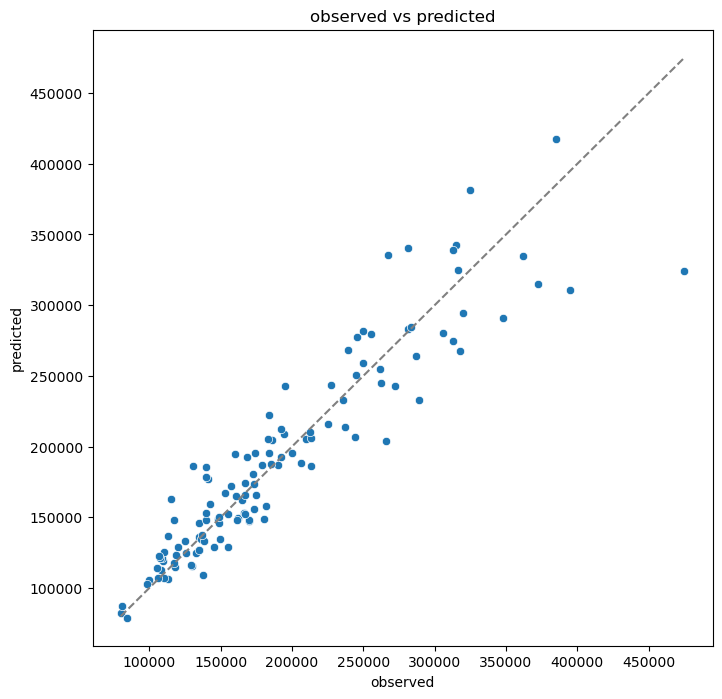

In [20]:
# plot observed vs predicted
plt.figure(figsize=(8, 8))
# add identity line
plt.plot([np.exp(y_test).min(), np.exp(y_test).max()], [np.exp(y_test).min(), np.exp(y_test).max()], c='gray', linestyle='--')
# get residuals
sns.scatterplot(x=np.exp(y_test), y=np.exp(y_pred))
plt.xlabel('observed')  
plt.ylabel('predicted')
plt.title('observed vs predicted')
plt.show()

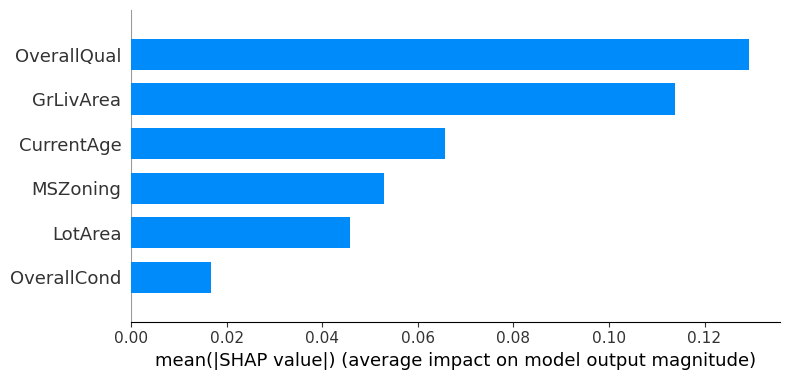

In [21]:
# look shape values
# import Pool
from catboost import Pool
# import shap
import shap
# get shape values
shap_values = cb_model.get_feature_importance(Pool(X_train, label=y_train, cat_features=cat_cols), type='ShapValues')
# plot
plt.figure(figsize=(8, 8))
shap.summary_plot(shap_values[:, :-1], X_train, plot_type='bar')
plt.show()


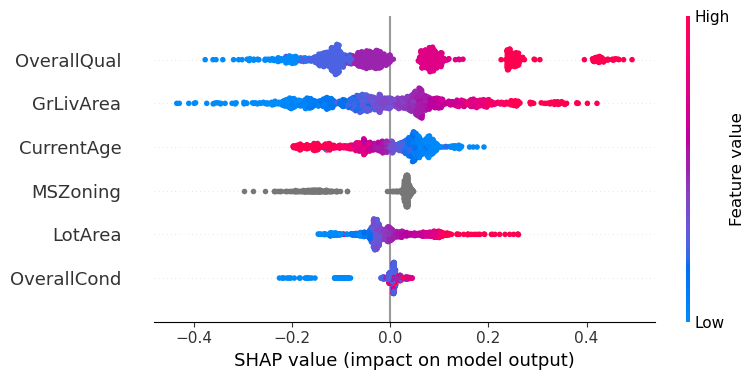

In [22]:
# plot bee swarm
plt.figure(figsize=(8, 8))
shap.summary_plot(shap_values[:, :-1], X_train)
plt.show()

### catboost + monotonicity

In [23]:
# monotonicity constraints
# monotonicity constraints in current age
monotone_constrains = "GrLivArea:1,OverallQual:1,CurrentAge:-1,OverallCond:1,LotArea:1"

# fit catboost
cb_model = cb.CatBoostRegressor(
    loss_function='RMSE',
    iterations=1000,
    learning_rate=0.5,
    random_seed=42,
    verbose=True,
    monotone_constraints=monotone_constrains
)
# fit
cb_model.fit(X_train, y_train, cat_features=cat_cols, plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2796643	total: 2.81ms	remaining: 2.81s
1:	learn: 0.2210439	total: 5.93ms	remaining: 2.96s
2:	learn: 0.1978917	total: 9.55ms	remaining: 3.17s
3:	learn: 0.1883331	total: 13.6ms	remaining: 3.38s
4:	learn: 0.1824181	total: 17.7ms	remaining: 3.51s
5:	learn: 0.1800273	total: 20.8ms	remaining: 3.45s
6:	learn: 0.1782264	total: 24.6ms	remaining: 3.49s
7:	learn: 0.1780625	total: 26.9ms	remaining: 3.33s
8:	learn: 0.1775735	total: 28.9ms	remaining: 3.18s
9:	learn: 0.1760884	total: 31.5ms	remaining: 3.12s
10:	learn: 0.1752746	total: 33.6ms	remaining: 3.02s
11:	learn: 0.1759648	total: 35.6ms	remaining: 2.93s
12:	learn: 0.1761003	total: 37.9ms	remaining: 2.88s
13:	learn: 0.1769442	total: 40.8ms	remaining: 2.87s
14:	learn: 0.1753902	total: 42.5ms	remaining: 2.79s
15:	learn: 0.1742320	total: 44.7ms	remaining: 2.75s
16:	learn: 0.1736422	total: 47.5ms	remaining: 2.74s
17:	learn: 0.1745580	total: 49.5ms	remaining: 2.7s
18:	learn: 0.1718298	total: 51.6ms	remaining: 2.66s
19:	learn: 0.1691084	to

In [24]:
# predict
y_pred = cb_model.predict(X_test)

# get metrics
regression_metrics(y_test, y_pred)
regression_metrics(y_test, y_pred, exp=True)

metrics (log)
rmse: 0.1451
mae: 0.1128
mape: 0.0093



metrics
rmse: 33077.8412
mae: 21901.7865
mape: 0.1076





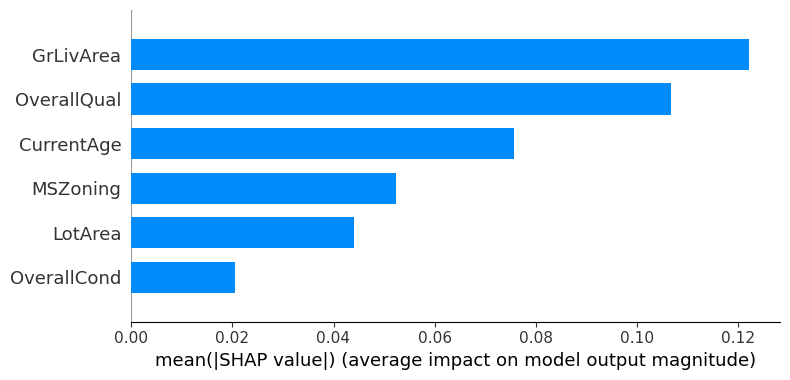

In [25]:
# look shape values
# import Pool
from catboost import Pool
# import shap
import shap
# get shape values
shap_values = cb_model.get_feature_importance(Pool(X_train, label=y_train, cat_features=cat_cols), type='ShapValues')
# plot
plt.figure(figsize=(8, 8))
shap.summary_plot(shap_values[:, :-1], X_train, plot_type='bar')
plt.show()


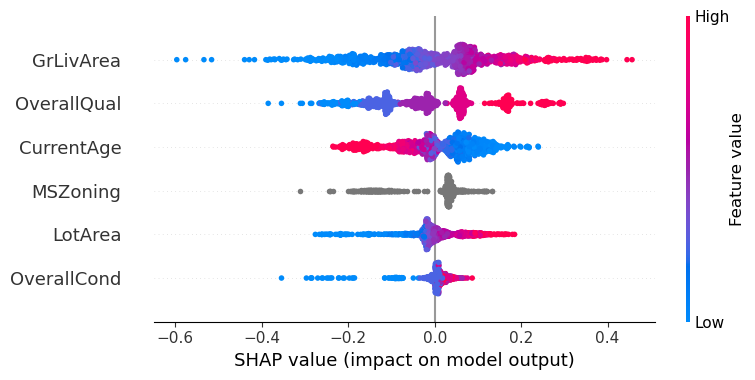

In [26]:
# plot bee swarm
plt.figure(figsize=(8, 8))
shap.summary_plot(shap_values[:, :-1], X_train)
plt.show()

# Best Model

catboost with monotonocity

the rationale is that even though the model is not the best in terms of RMSE, it is the best in terms of interpretability. The model is able to explain the relationship between the features and the target variable.

In [27]:
# monotonicity constraints
monotone_constrains = "GrLivArea:1,OverallQual:1,CurrentAge:-1,OverallCond:1,LotArea:1"

# fit catboost
cb_model = cb.CatBoostRegressor(
    loss_function='RMSE',
    iterations=1000,
    learning_rate=0.5,
    random_seed=42,
    verbose=True,
    monotone_constraints=monotone_constrains
)
# fit
cb_model.fit(X_train, y_train, cat_features=cat_cols, plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2796643	total: 1.97ms	remaining: 1.96s
1:	learn: 0.2210439	total: 4.13ms	remaining: 2.06s
2:	learn: 0.1978917	total: 6.19ms	remaining: 2.06s
3:	learn: 0.1883331	total: 11.5ms	remaining: 2.85s
4:	learn: 0.1824181	total: 14.9ms	remaining: 2.97s
5:	learn: 0.1800273	total: 18.6ms	remaining: 3.08s
6:	learn: 0.1782264	total: 21.6ms	remaining: 3.06s
7:	learn: 0.1780625	total: 27.3ms	remaining: 3.38s
8:	learn: 0.1775735	total: 31.7ms	remaining: 3.49s
9:	learn: 0.1760884	total: 46ms	remaining: 4.55s
10:	learn: 0.1752746	total: 63.3ms	remaining: 5.7s
11:	learn: 0.1759648	total: 65.6ms	remaining: 5.4s
12:	learn: 0.1761003	total: 67.7ms	remaining: 5.14s
13:	learn: 0.1769442	total: 69.6ms	remaining: 4.9s
14:	learn: 0.1753902	total: 72ms	remaining: 4.72s
15:	learn: 0.1742320	total: 73.9ms	remaining: 4.54s
16:	learn: 0.1736422	total: 75.8ms	remaining: 4.38s
17:	learn: 0.1745580	total: 80.1ms	remaining: 4.37s
18:	learn: 0.1718298	total: 84.8ms	remaining: 4.38s
19:	learn: 0.1691084	total: 8

In [28]:
# predict
y_pred = cb_model.predict(X_test)

# get metrics
regression_metrics(y_test, y_pred)
regression_metrics(y_test, y_pred, exp=True)

metrics (log)
rmse: 0.1451
mae: 0.1128
mape: 0.0093



metrics
rmse: 33077.8412
mae: 21901.7865
mape: 0.1076





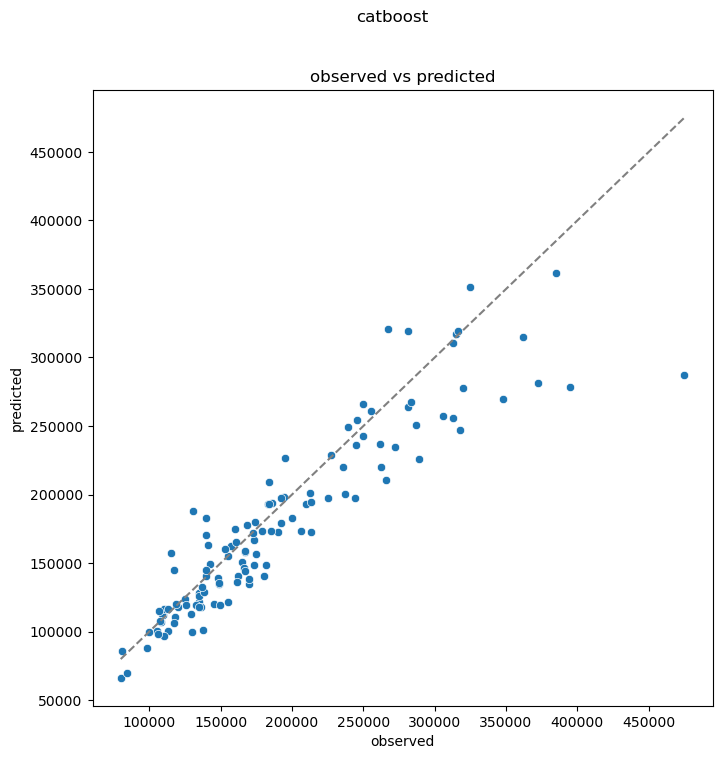

In [29]:
# plot observed vs predicted
plt.figure(figsize=(8, 8))
# add identity line
plt.plot([np.exp(y_test).min(), np.exp(y_test).max()], [np.exp(y_test).min(), np.exp(y_test).max()], c='gray', linestyle='--')
# get residuals
sns.scatterplot(x=np.exp(y_test), y=np.exp(y_pred))
plt.xlabel('observed')  
plt.ylabel('predicted')
plt.title('observed vs predicted')
# subtitle: catboost 
plt.suptitle('catboost')
plt.show()

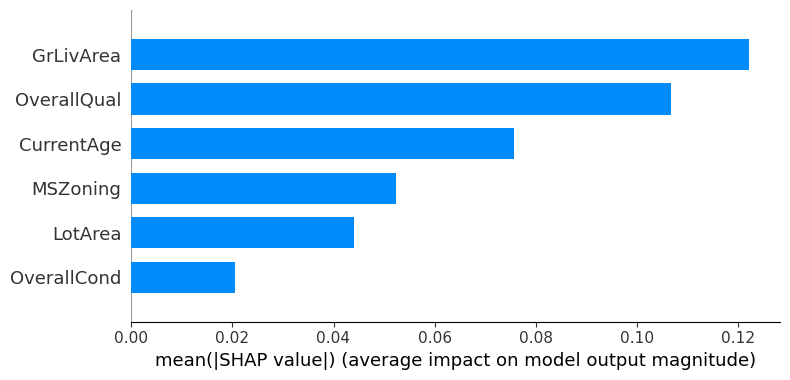

In [30]:
# get shape values
shap_values = cb_model.get_feature_importance(Pool(X_train, label=y_train, cat_features=cat_cols), type='ShapValues')
# plot
plt.figure(figsize=(8, 8))
shap.summary_plot(shap_values[:, :-1], X_train, plot_type='bar')
plt.show()

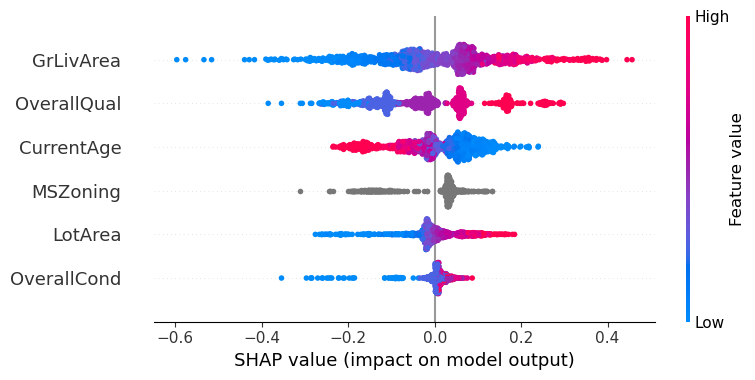

In [31]:
# plot bee swarm
plt.figure(figsize=(8, 8))
shap.summary_plot(shap_values[:, :-1], X_train)
plt.show()

In [32]:
# save model
cb_model.save_model('../models/catboost_model.cbm')

# Sandbox

In [33]:
X_train.iloc[0]

CurrentAge       11
GrLivArea      2060
LotArea        8755
OverallCond       5
OverallQual       7
MSZoning         RL
Name: 942, dtype: object

In [40]:
np.exp(y_train.iloc[0])

214000.0000000001